In [1]:
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
import numpy as np
from scipy.interpolate import make_interp_spline
import cartopy.crs as ccrs

In [2]:
df24 = pd.read_csv('/pampa/cloutier/etc24_consec.csv')

# open netcdf mask file
file = '/pampa/picart/Masks/mask_GEM5_ERA5grid'
data = xr.open_dataset(file)

# export netcdf to dataframe
mask = data.to_dataframe()

# drop index lat lon, but keep columns
mask = mask.reset_index()

# keep in mask values where HU = true
maskT = mask.loc[mask.HU != False]

## Create 2020 etc map

In [192]:
# get year 2020
djf20 = djf.loc[djf.datetime // 1000000 == 2020]
mam20 = mam.loc[mam.datetime // 1000000 == 2020]
jja20 = jja.loc[jja.datetime // 1000000 == 2020]
son20 = son.loc[son.datetime // 1000000 == 2020]

#### Get grid points that define the border of CRCM6 domain

In [6]:
# Define the radius of neighboring grid points to consider
radius = 0.25

# Initialize an empty list to store the filtered grid points
filtered_points = []

# Iterate through each grid point in the dataframe
for i, row in mask.iterrows():
    if row['HU'] == True:
        lat = row['lat']
        lon = row['lon']

        # Find the neighboring grid points within the specified radius
        neighbors = mask[
            (mask['lat'] >= lat - radius) & (mask['lat'] <= lat + radius) &
            (mask['lon'] >= lon - radius) & (mask['lon'] <= lon + radius)
        ]

        # Check if there is at least one false 'HU' value in the neighbors
        if neighbors['HU'].isin([False]).any():
            filtered_points.append(row)

# Create a new dataframe with the filtered grid points
filtered_mask = pd.DataFrame(filtered_points)

#filtered_mask.to_csv('/pampa/cloutier/outline_crcm6_domain.csv')

print(neighbors)

         lat     lon     HU
34758  66.00  268.50   True
34759  66.00  268.75   True
34760  66.00  269.00   True
34999  66.25  268.50   True
35000  66.25  268.75   True
35001  66.25  269.00  False
35240  66.50  268.50  False
35241  66.50  268.75  False
35242  66.50  269.00  False


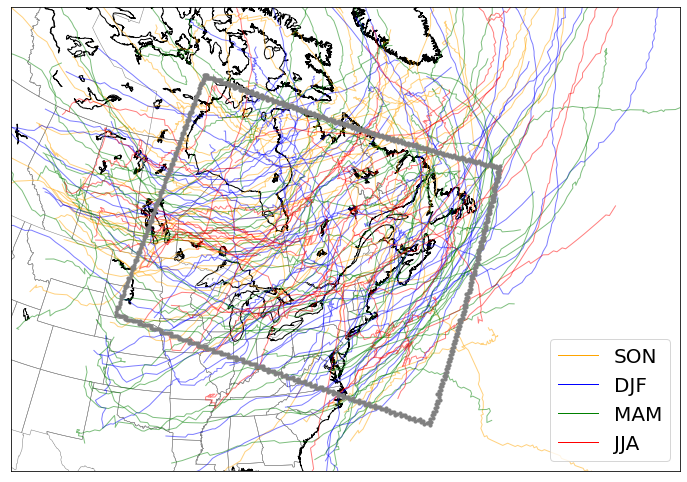

<Figure size 432x288 with 0 Axes>

In [217]:
# Create the Basemap object
from matplotlib.lines import Line2D

m = Basemap(llcrnrlon=-109, llcrnrlat=28, urcrnrlon=-15, urcrnrlat=45, 
            resolution='i', lat_0=60, lon_0=-90, area_thresh=1500., projection='lcc')

fig = plt.figure(figsize=(12, 9))

# Draw the coastline, countries, and states
m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Define a list of dataframes and colors for each season
dataframes = [son20, djf20, mam20, jja20]
colors = ['orange', 'blue', 'green', 'red']
labels = ['SON',  'DJF', 'MAM', 'JJA']

#Iterate over each dataframe and its corresponding color
for df, color in zip(dataframes, colors):
    # Iterate over each storm in the current dataframe
    for storm_id, storm_data in df.groupby('storm'):
        # Convert latitude and longitude to map projection coordinates
        lat = storm_data['latitude'].tolist()
        lon = storm_data['longitude'].tolist()
        x, y = m(lon, lat)
        
        # Plot the line for the current storm with the corresponding color
        m.plot(x, y, color=color, linewidth=1, alpha=0.5)

lat = filtered_mask['lat'].tolist()
lon = filtered_mask['lon'].tolist()
x, y = m(lon, lat)
m.scatter(x, y, color='gray', s=10, alpha=1, zorder=3)

#Create a custom legend outside the loop
legend_elements = [Line2D([0], [0], color='orange', linewidth=1, label='SON'),
                   Line2D([0], [0], color='blue', linewidth=1, label='DJF'),
                   Line2D([0], [0], color='green', linewidth=1, label='MAM'),
                   Line2D([0], [0], color='red', linewidth=1, label='JJA')]

#Add the legend to the plot
plt.legend(handles=legend_elements, loc='lower right', fontsize="20")

plt.show()
plt.savefig('/pampa/cloutier/tracks_2020.png')


### PLOT DENSITY

In [3]:
son = pd.read_csv('/pampa/cloutier/test_son_density.csv')

In [84]:
# print('min lat = ', df['lat'].min())
# print('max lat = ', df['lat'].max())
# print('min lon = ', df['lon'].min())
# print('max lon = ', df['lon'].max())

#son = son.groupby(['lat', 'lon'])['avg_per_season'].mean().reset_index()
#print(son)

dup = pd.read_csv('/pampa/cloutier/test_son_density.csv')
nodup = dup.drop_duplicates()

52193
52193


In [ ]:
# color palette

# 1 - 2   : F9FBCC
# 2 - 3   : E6F5B3
# 3 - 4   : C8E9B3
# 4 - 5   : 8ED4BA
# 5 - 6   : 57BFC1
# 6 - 7   : 32A8C5
# 7 - 8   : 1F85BC
# 8 - 9   : 225DA6
# 9 - 10  : 263A99
# 10 - 11 : 12276E
# 11 +    : 041D5D


### Carte avec test_densite_mam.csv, soit la densité moyennée sur 250km

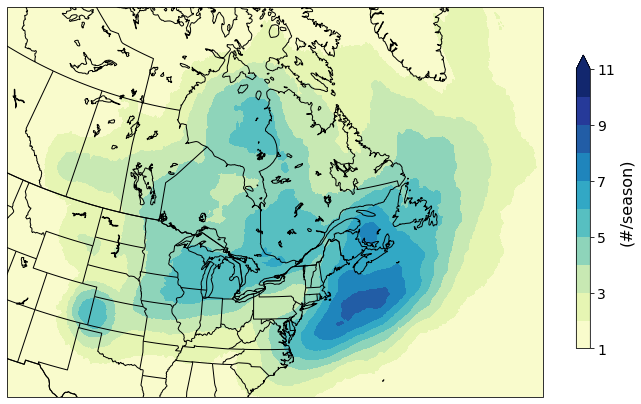

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import griddata
import numpy as np
from matplotlib.colors import ListedColormap

# Load the CSV file
data1 = pd.read_csv('/pampa/cloutier/test_densite_mam.csv')

# Extract the necessary columns
lat = data1['lat']
lon = data1['lon']
storms = data1['storm_count']

# Define the grid for interpolation
grid_x, grid_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]

# Perform nearest neighbor interpolation
storms_interp = griddata((lon, lat), storms, (grid_x, grid_y), method='nearest')

# Create a figure and axes for the map
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.LambertConformal(
    central_longitude=-80, central_latitude=51)})

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', 
                                   scale='50m', edgecolor='black', facecolor='none'))
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                   scale='50m', edgecolor='black', facecolor='none'))

# Filter lakes based on area threshold
lakes = NaturalEarthFeature(category='physical', name='lakes', scale='50m')
filtered_lakes = cfeature.ShapelyFeature([geom for geom in lakes.geometries() if geom.area >= 0.1],
                                         ccrs.PlateCarree(), edgecolor='none')
ax.add_feature(filtered_lakes, edgecolor='black', facecolor='none')

# Plot the filled contours with custom colorbar
color_list = ['#F9FBCC', '#E6F5B3', '#C8E9B3', '#8ED4BA', '#57BFC1',
              '#32A8C5', '#1F85BC', '#225DA6', '#263A99', '#12276E']
cmap = ListedColormap(color_list)
levels = np.arange(1, 12)  # Values from 1 to 11

# Plot the filled contours
contour = ax.contourf(grid_x, grid_y, storms_interp, levels=levels, 
                      extend='max', cmap=cmap, transform=ccrs.PlateCarree())

# Add a colorbar for the legend
# Set map boundaries and add a title
lat_min = 31.7
lat_max = 67.4
lon_min = 249.5
lon_max = 315
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add a colorbar for the legend
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', shrink = 0.6, ticks=[1,3,5,7,9,11])
cbar.set_label(label='(#/season)', size=16)
cbar.ax.tick_params(labelsize=14)

# Finally, display the map
plt.show()
#plt.savefig('/pampa/cloutier/density_map_test_mam.png')

### Test avec etc_vort_den.csv, soit la densité à chaque point de grille

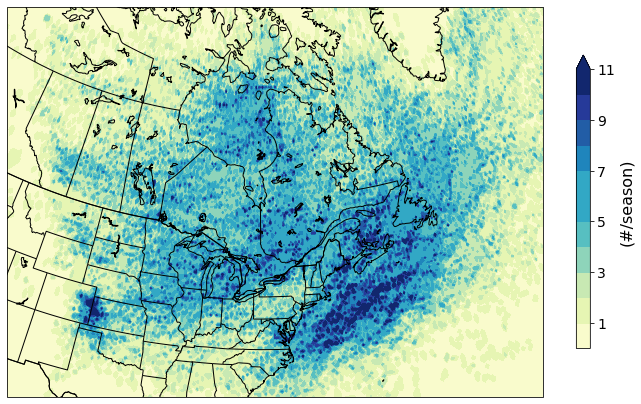

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import griddata
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter

# Load the CSV file
data = pd.read_csv('/pampa/cloutier/etc24_vort_den.csv')
data = data.loc[data.season=='MAM']

# Extract the necessary columns
lat = data['latitude']
lon = data['longitude']
storms = data['storm_count']

# Define the grid for interpolation
grid_x, grid_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]

# Perform nearest neighbor interpolation
storms_interp = griddata((lon, lat), storms, (grid_x, grid_y), method='nearest')

# Create a figure and axes for the map
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.LambertConformal(
    central_longitude=-80, central_latitude=51)})

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', 
                                   scale='50m', edgecolor='black', facecolor='none'))
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                   scale='50m', edgecolor='black', facecolor='none'))

# Filter lakes based on area threshold
lakes = NaturalEarthFeature(category='physical', name='lakes', scale='50m')
filtered_lakes = cfeature.ShapelyFeature([geom for geom in lakes.geometries() if geom.area >= 0.1],
                                         ccrs.PlateCarree(), edgecolor='none')
ax.add_feature(filtered_lakes, edgecolor='black', facecolor='none')

# Plot the filled contours with custom colorbar
color_list = ['#F9FBCC', '#E6F5B3', '#C8E9B3', '#8ED4BA', '#57BFC1',
              '#32A8C5', '#1F85BC', '#225DA6', '#263A99', '#12276E']
cmap = ListedColormap(color_list)
levels = np.arange(0, 12)  # Values from 1 to 11

# Plot the filled contours
contour = ax.contourf(grid_x, grid_y, storms_interp, levels=levels, 
                      extend='max', cmap=cmap, transform=ccrs.PlateCarree())

# Add a colorbar for the legend
# Set map boundaries and add a title
lat_min = 31.7
lat_max = 67.4
lon_min = 249.5
lon_max = 315
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add a colorbar for the legend
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', shrink = 0.6, ticks=[1,3,5,7,9,11])
cbar.set_label(label='(#/season)', size=16)
cbar.ax.tick_params(labelsize=14)

# Finally, display the map
plt.show()
#plt.savefig('/pampa/cloutier/density_map_test_mam.png')

In [84]:
print(np.min(storms_smoothed), np.max(storms_smoothed))

1 1
